In [1]:
from ms_data_funcs import *
from transformer_funcs import *

import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print("PyTorch version:", torch.__version__)
    print("CUDA version:", torch.version.cuda)
    print("Number of available GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

CUDA is available.
PyTorch version: 2.0.1+cu118
CUDA version: 11.8
Number of available GPUs: 1
GPU name: NVIDIA GeForce RTX 3080


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('data/MoNA/in-silico-SMILES.csv') 
print(f"Original shape: {df.shape}")

/tmp/ipykernel_4734/3583281888.py:1: DtypeWarning: Columns (7,8,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/MoNA/in-silico-SMILES.csv')


Original shape: (1837926, 18)


In [5]:
# Minimal test
df = df.iloc[0:5000]

In [6]:
method='direct'

In [7]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['molecular_formula'])
max_mz = calculate_max_mz(df)

In [8]:
df['molecular_formula'].unique().shape

(1054,)

In [9]:
smiles_vocabs = get_or_create_smiles_vocabs(df)

Loading existing character vocabulary...
SMILES vocabulary size (character): 32
Loading existing atom_wise vocabulary...
SMILES vocabulary size (atom_wise): 12
Loading existing substructure vocabulary...
SMILES vocabulary size (substructure): 38759


In [10]:
results = {}
print(f"\nSpectra tokenized with {method} tokenization:")
print(f"\nSMILES tokenized with {'character'} tokenization")
smiles_vocab = smiles_vocabs['character']

train_loader, test_loader = load_tokenized_data_with_smiles(df, df, 
                                                            method, 
                                                            smiles_vocab, 
                                                            max_mz=max_mz)

#num_classes = len(label_encoder.classes_)
smiles_vocab_size = len(smiles_vocab)

# sample batch used for input dimensions
sample_batch, _ = next(iter(train_loader))
print("Sample shape:", sample_batch.shape)
embed_depth = sample_batch.shape[3]


Spectra tokenized with direct tokenization:

SMILES tokenized with character tokenization
Sample shape: torch.Size([32, 1, 112, 16])


In [11]:
model = MS_VIT_Seq2Seq(
    smiles_vocab_size=len(smiles_vocab),
    embed_depth=embed_depth,
    d_model=64,           # Reduced from 256
    nhead=4,              # Reduced from 8
    num_layers=2,         # Reduced from 6
    dim_feedforward=256,  # Reduced from 2048
    dropout=0.1,
    num_classes=None
)

MS_VIT_Seq2Seq(
  (embedding): Linear(in_features=16, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (smiles_embedding): Embedding(32, 64)
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_at

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion_cls = nn.CrossEntropyLoss()
criterion_seq = nn.CrossEntropyLoss(ignore_index=smiles_vocab['<pad>'])

model, history = train_model_seq2seq(model, train_loader, test_loader, 
                                     optimizer, criterion_seq, 
                                     num_epochs=50, evaluate=True, verbose=1,
                                     checkpoint_path="./model_checkpoints/",
                                     meta_tag=(method+"_character"))

Saving checkpoints to ./model_checkpoints/checkpoint_2


Epoch 1/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 31/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 31/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 32/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 32/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 33/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 33/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 34/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 34/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 35/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 35/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 36/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 36/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 37/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 37/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 38/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 38/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 39/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 39/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 40/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 40/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 41/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 41/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 42/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 42/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 43/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 43/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 44/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 44/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 45/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 45/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 46/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 46/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 47/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 47/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 48/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 48/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 49/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 49/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 50/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 50/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

In [13]:
seq_accuracy, avg_seq_loss = evaluate_model_seq2seq(model, test_loader, smiles_vocab)

True SMILES: C1=CC2=C(C=C1C)C(=C(N2[Si](C)(C)C)C)C
Pred SMILES: C1=CC2=C(C=C1C)C(=C(N[[Si](C)(C)C)C)C1C

True SMILES: O=C(OCC)CC(O[Si](C)(C)C)(C)CC
Pred SMILES: O=C(OCC)CC(O[Si](C)(C)C)(C)CC

True SMILES: O=C(O[Si](C)(C)C)C(N)C(C)C
Pred SMILES: O=C(O[Si](C)(C)C)C(N)C(C)C

True SMILES: O=C(OC)CC(O[Si](C)(C)C)C
Pred SMILES: O=C(OC)CC(O[Si](C)(C)C)C

True SMILES: O(CCCC)[Si](C)(C)C
Pred SMILES: O(CCCC)[Si](C)(C)C

True SMILES: O(C1CC2CCC1C2)[Si](C)(C)C
Pred SMILES: O(C1CC2CCC1C2)[Si](C)(C)C

True SMILES: OC1=CC=CC(O[Si](C)(C)C)=C1
Pred SMILES: OC1=CC=CC(O[Si](C)(C)C)=C1

True SMILES: N(O[Si](C)(C)C)=C(C1=CC=C(OC)C=C1)C
Pred SMILES: N(O[Si](C)(C)C)=C(C1=CC=C(OC)C=C1)C

True SMILES: O(C=1C=CC=CC1N)[Si](C)(C)C
Pred SMILES: O(C=1C=CC=CC1N)[Si](C)(C)C

True SMILES: O(C)CCC(C=1C=CC=CC1)CCO[Si](C)(C)C
Pred SMILES: O(C)CCC(C=1C=CC=CC1)CCO[Si](C)(C)C

True SMILES: N#CC=1C(=S)N(C(=CC1C)C)[Si](C)(C)C
Pred SMILES: N1CC=1C(=SiN(C(=CC1C)C)[Si](C)(C)C

True SMILES: O(C1=CC=C(C=C1)C(C)(C)CC)[Si](C)(C)C
P

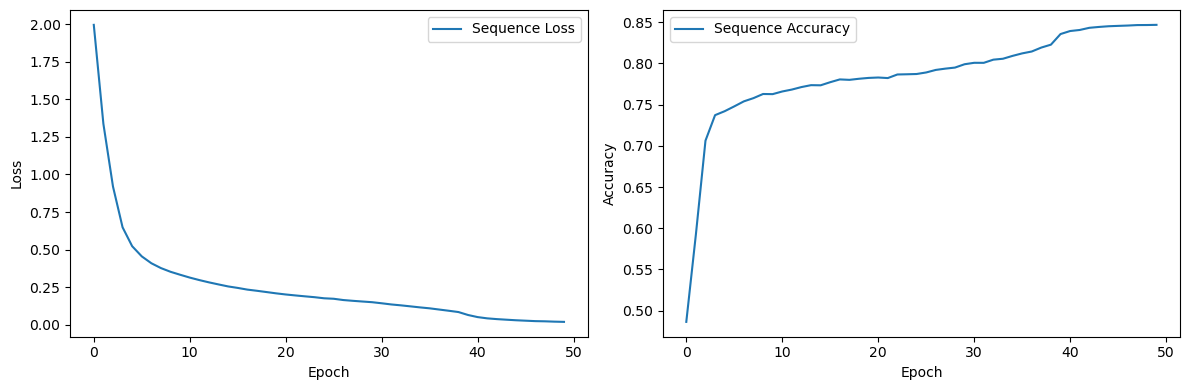

In [15]:
# Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['seq_loss'].values(), label='Sequence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['seq_accuracy'].values(), label='Sequence Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
results = {}
print(f"\nSpectra tokenized with {method} tokenization:")
print(f"\nSMILES tokenized with {'atom_wise'} tokenization")
smiles_vocab = smiles_vocabs['atom_wise']

train_loader, test_loader = load_tokenized_data_with_smiles(df, df, 
                                                            method, 
                                                            smiles_vocab, 
                                                            max_mz=max_mz)

#num_classes = len(label_encoder.classes_)
smiles_vocab_size = len(smiles_vocab)

# sample batch used for input dimensions
sample_batch, target_batch = next(iter(train_loader))
print("Spectra shape:", sample_batch.shape)
print("SMILES shape:", target_batch.shape)
embed_depth = sample_batch.shape[3]


Spectra tokenized with direct tokenization:

SMILES tokenized with atom_wise tokenization
Sample shape: torch.Size([32, 1, 112, 16])


In [20]:
model = MS_VIT_Seq2Seq(
    smiles_vocab_size=len(smiles_vocab),
    embed_depth=embed_depth,
    d_model=64,           # Reduced from 256
    nhead=4,              # Reduced from 8
    num_layers=2,         # Reduced from 6
    dim_feedforward=256,  # Reduced from 2048
    dropout=0.1,
    num_classes=None
)

MS_VIT_Seq2Seq(
  (embedding): Linear(in_features=16, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (smiles_embedding): Embedding(12, 64)
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_at

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion_cls = nn.CrossEntropyLoss()
criterion_seq = nn.CrossEntropyLoss(ignore_index=smiles_vocab['<pad>'])

model, history = train_model_seq2seq(model, train_loader, test_loader, 
                                     optimizer, criterion_seq, 
                                     num_epochs=50, evaluate=True, verbose=1,
                                     checkpoint_path="./model_checkpoints/",
                                     meta_tag=(method+"_atom_wise"))

Saving checkpoints to ./model_checkpoints/checkpoint_4


Epoch 1/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/50 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/50 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
seq_accuracy, avg_seq_loss = evaluate_model_seq2seq(model, test_loader, smiles_vocab)

In [ ]:
# Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['seq_loss'].values(), label='Sequence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['seq_accuracy'].values(), label='Sequence Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
results = {}
print(f"\nSpectra tokenized with {method} tokenization:")
print(f"\nSMILES tokenized with {'substructure'} tokenization")
smiles_vocab = smiles_vocabs['substructure']

train_loader, test_loader = load_tokenized_data_with_smiles(df, df, 
                                                            method, 
                                                            smiles_vocab, 
                                                            max_mz=max_mz)

#num_classes = len(label_encoder.classes_)
smiles_vocab_size = len(smiles_vocab)

# sample batch used for input dimensions
sample_batch, _ = next(iter(train_loader))
print("Sample shape:", sample_batch.shape)
embed_depth = sample_batch.shape[3]

In [ ]:
model = MS_VIT_Seq2Seq(
    smiles_vocab_size=len(smiles_vocab),
    embed_depth=embed_depth,
    d_model=64,           # Reduced from 256
    nhead=4,              # Reduced from 8
    num_layers=2,         # Reduced from 6
    dim_feedforward=256,  # Reduced from 2048
    dropout=0.1,
    num_classes=None
)
print(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion_cls = nn.CrossEntropyLoss()
criterion_seq = nn.CrossEntropyLoss(ignore_index=smiles_vocab['<pad>'])

model, history = train_model_seq2seq(model, train_loader, test_loader, 
                                     optimizer, criterion_seq, 
                                     num_epochs=50, evaluate=True, verbose=1,
                                     checkpoint_path="./model_checkpoints/",
                                     meta_tag=(method+"_substructure"))

In [ ]:
seq_accuracy, avg_seq_loss = evaluate_model_seq2seq(model, test_loader, smiles_vocab)

In [ ]:
# Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['seq_loss'].values(), label='Sequence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['seq_accuracy'].values(), label='Sequence Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()